In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

Epoch 1/50


C:\Users\Vaquita\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0080
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0335
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 - val_loss: 0.0974
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0548 - val_loss: 0.0325
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0594 - val_loss: 0.0090
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - val_loss: 0.0014
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4995e-04 - val_loss: 0.0020
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0

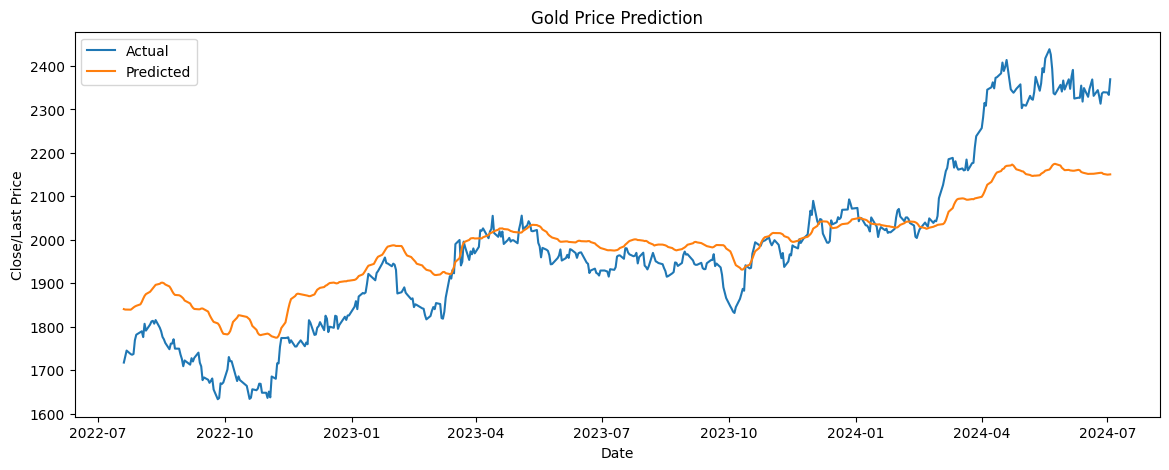

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Close/Last for the next day: 2150.8349609375


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import keras_tuner as kt

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Parse dates and set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Sort the dataset by date
df.sort_index(inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Feature engineering: Create moving averages without leakage
df['MA_5'] = df['Close/Last'].shift(1).rolling(window=5).mean()
df['MA_10'] = df['Close/Last'].shift(1).rolling(window=10).mean()
df['MA_20'] = df['Close/Last'].shift(1).rolling(window=20).mean()

# Add lagged features
for lag in range(1, 4):  # Creating lagged features for 1, 2, and 3 days
    df[f'Close_Lag_{lag}'] = df['Close/Last'].shift(lag)
    df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
    df[f'Open_Lag_{lag}'] = df['Open'].shift(lag)
    df[f'High_Lag_{lag}'] = df['High'].shift(lag)
    df[f'Low_Lag_{lag}'] = df['Low'].shift(lag)

# Drop rows with NaN values generated by moving averages and lagged features
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Feature selection
features = ['Volume', 'Open', 'High', 'Low', 'MA_5', 'MA_10', 'MA_20'] + \
           [f'Close_Lag_{lag}' for lag in range(1, 4)] + \
           [f'Volume_Lag_{lag}' for lag in range(1, 4)] + \
           [f'Open_Lag_{lag}' for lag in range(1, 4)] + \
           [f'High_Lag_{lag}' for lag in range(1, 4)] + \
           [f'Low_Lag_{lag}' for lag in range(1, 4)]

X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Data scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Define the hypermodel
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32),
                   return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='gold_price_prediction'
)

# Run the tuner
tuner.search(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2, shuffle=False)

# Make predictions
y_pred_scaled = best_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model
y_test_actual = scaler_y.inverse_transform(y_test_seq)

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(test.index[time_steps:], y_test_actual, label='Actual')
plt.plot(test.index[time_steps:], y_pred, label='Predicted')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()

# Forecasting future values
last_sequence = X_test_scaled[-time_steps:]
last_sequence = np.expand_dims(last_sequence, axis=0)
future_prediction_scaled = best_model.predict(last_sequence)
future_prediction = scaler_y.inverse_transform(future_prediction_scaled)
print(f'Predicted Close/Last for the next day: {future_prediction[0][0]}')

C:\Users\Vaquita\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |units_1
32                |32                |units_2
0.1               |0.1               |dropout
64                |64                |dense_units


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0035 - val_loss: 0.0108
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0130 - val_loss: 0.0036
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0169 - val_loss: 0.0029
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0190 - val_loss: 0.0439
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0432 - val_loss: 0.0645
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0553 - val_loss: 0.0916
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0656 - val_loss: 0.0314
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0753 - val_loss: 0.0053
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/ste

# Base

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('goldstock.csv')
df = df.drop('Index', axis=1)
df = df.set_index('Date')
df.index = pd.to_datetime(df.index, dayfirst=True)

df_with_volume = df.copy()

df_without_volume = df.drop(columns=['Volume'])

scaler = StandardScaler()

df_with_volume[['Close/Last', 'Volume', 'Open', 'High', 'Low']] = scaler.fit_transform(df_with_volume[['Close/Last', 'Volume', 'Open', 'High', 'Low']])



# Sort the dataframe by date
df_without_volume = df_without_volume.sort_values('Date')

# Define window sizes for lag features and rolling statistics
window_sizes = [10, 20, 50, 200]
rolling_windows = [20, 50, 200]

# Dictionary to store dataframes for each window size
dfs_by_window_size = {}

# Create separate dataframes for each window size
for window_size in window_sizes:
    # Create a copy of the original dataframe
    df_window = df_without_volume.copy()
    
    # Create lag features for the current window size
    for i in range(1, window_size + 1):
        df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
    """
    # Add rolling statistics for the current window size if applicable
    if window_size in rolling_windows:
        df_window[f'Close/Last_Rolling_Mean_{window_size}'] = df_window['Close/Last'].rolling(window=window_size).mean()
        df_window[f'Close/Last_Rolling_Std_{window_size}'] = df_window['Close/Last'].rolling(window=window_size).std()
    """
    # Drop rows with NaN values (which will be the first 'window_size' rows for the largest window size)
    df_window = df_window.dropna()
    
    # Reset index after dropping rows
    df_window = df_window.reset_index(drop=True)
    
    # Store the dataframe in the dictionary
    dfs_by_window_size[window_size] = df_window


C:\Users\Vaquita\AppData\Local\Temp\ipykernel_11776\2186368099.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
C:\Users\Vaquita\AppData\Local\Temp\ipykernel_11776\2186368099.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
C:\Users\Vaquita\AppData\Local\Temp\ipykernel_11776\2186368099.py:36: PerformanceWarning: DataFrame is highly fragmented.  T

# Data Preprocessing

# .1. Load DS

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Display the first 5 rows
print(df.head(5))

# Show the number of rows and columns
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

   Index        Date  Close/Last  Volume    Open    High     Low
0   2528  07/07/2014      1317.0   79110  1321.4  1321.7  1312.1
1   2527  08/07/2014      1316.5  126706  1320.8  1325.7  1314.3
2   2526  09/07/2014      1324.3  155101  1320.4  1333.4  1318.7
3   2525  10/07/2014      1339.2  167391  1325.0  1346.8  1325.0
4   2524  11/07/2014      1337.4   88470  1336.5  1340.4  1334.6
The dataset contains 2511 rows and 7 columns.


In [23]:
# Group by the 'Index' column
grouped = df.groupby('Index')

# Print all tuples with the same index, skipping groups with only one row
for index, group in grouped:
    if len(group) > 1:
        print(f"Index: {index}")
        print(group)
        print("\n")

# .2. Handling Missing Values

In [3]:
# Check for missing values
print(df.isnull().sum())

# Impute missing values with the mean of the column
# df.fillna(df.mean(), inplace=True)

# Verify that there are no missing values left
# print(df.isnull().sum())

Index         0
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


# .3. Resampling (not needed since our prediction is in days)

# .4. Scaling (skip for now)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select the features to scale (excluding the 'Date' column)
features = df_cleaned.columns.difference(['Date'])

# Fit and transform the features
df_cleaned[features] = scaler.fit_transform(df_cleaned[features])

# Display the first 5 rows of the scaled dataset
print(df_cleaned.head())
# ------------------------------------------------

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
data[features] = scaler.fit_transform(data[features])

# EDA

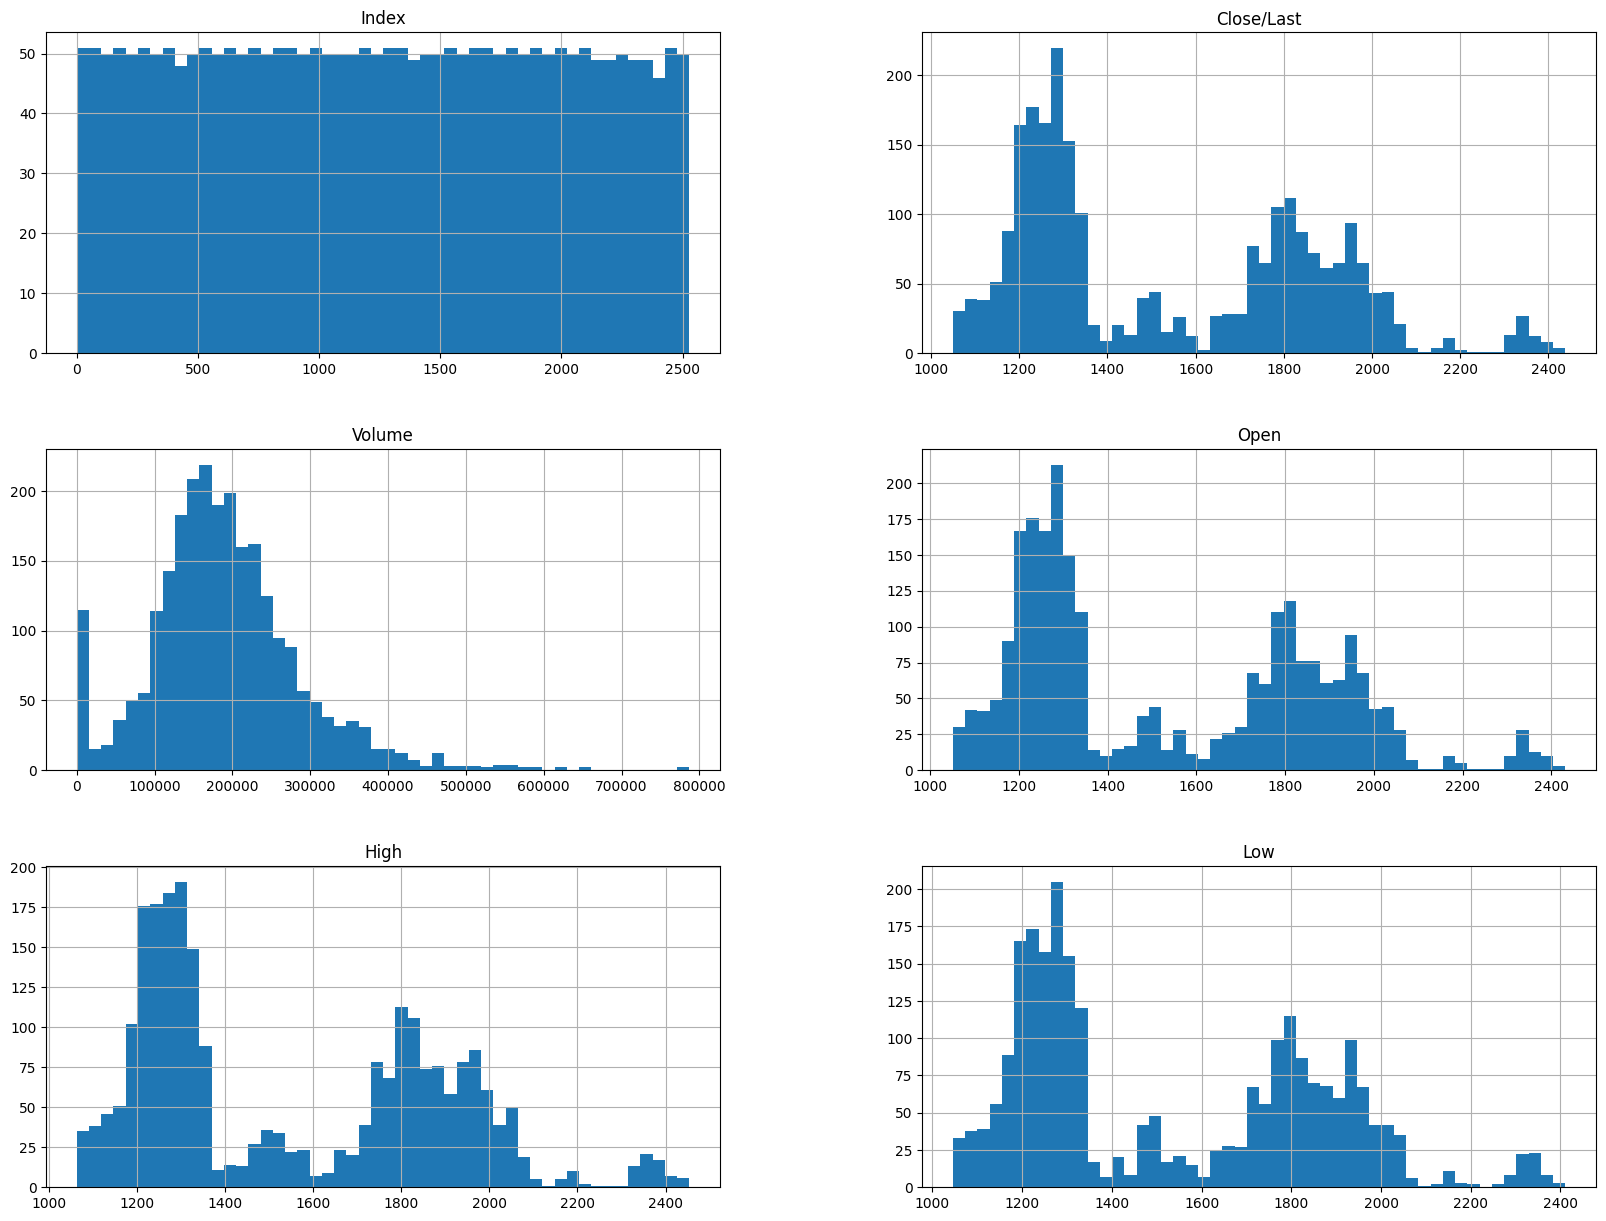

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for each feature
df.hist(bins=50, figsize=(20, 15))
plt.show()

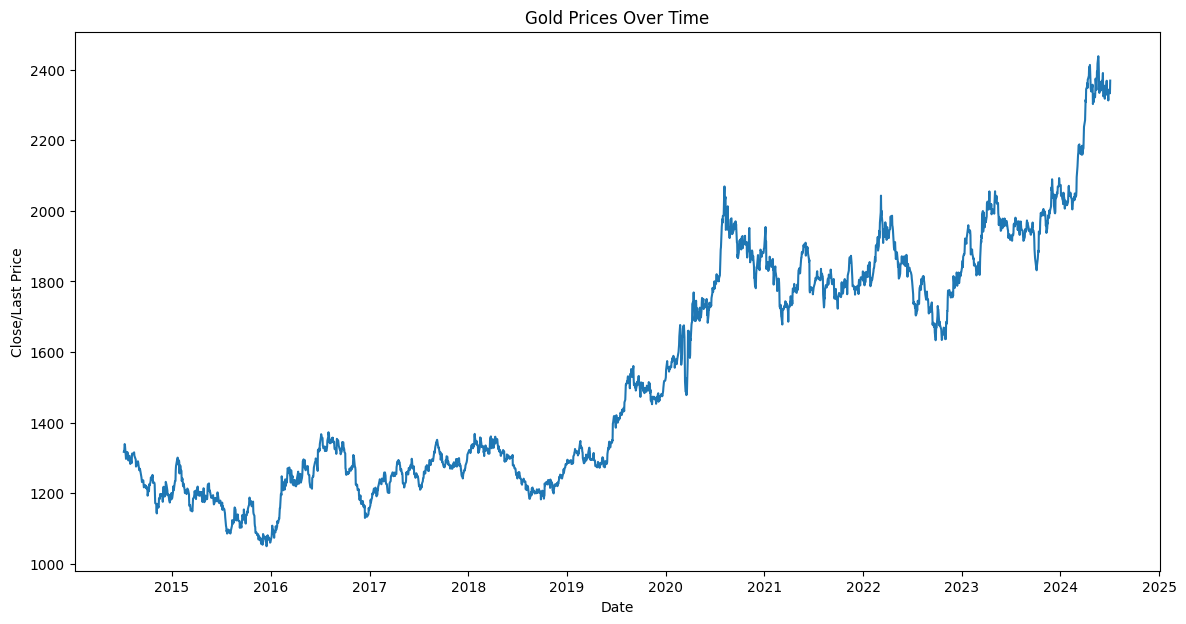

In [7]:


# Plot the 'Close/Last' prices over time
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'])
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.show()

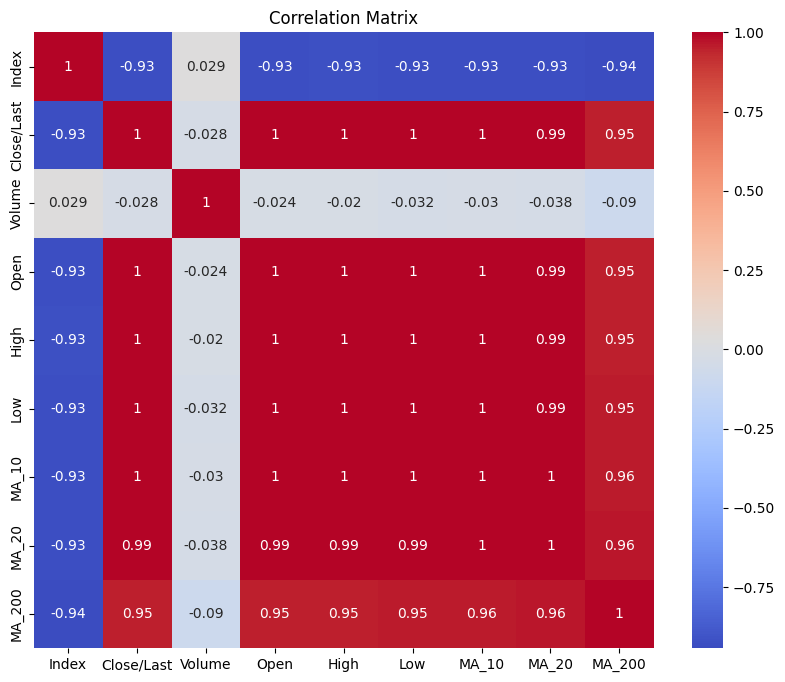

               Index  Close/Last    Volume      Open      High       Low  \
Index       1.000000   -0.928122  0.029336 -0.928065 -0.927075 -0.929516   
Close/Last -0.928122    1.000000 -0.028110  0.999112  0.999575  0.999644   
Volume      0.029336   -0.028110  1.000000 -0.023903 -0.019880 -0.032398   
Open       -0.928065    0.999112 -0.023903  1.000000  0.999535  0.999453   
High       -0.927075    0.999575 -0.019880  0.999535  1.000000  0.999356   
Low        -0.929516    0.999644 -0.032398  0.999453  0.999356  1.000000   
MA_10      -0.929250    0.996250 -0.030468  0.997056  0.996553  0.996622   
MA_20      -0.930332    0.993405 -0.037763  0.994131  0.993529  0.993856   
MA_200     -0.943166    0.953723 -0.089794  0.954114  0.953029  0.954856   

               MA_10     MA_20    MA_200  
Index      -0.929250 -0.930332 -0.943166  
Close/Last  0.996250  0.993405  0.953723  
Volume     -0.030468 -0.037763 -0.089794  
Open        0.997056  0.994131  0.954114  
High        0.996553  0.

In [10]:
import seaborn as sns
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(corr_matrix)

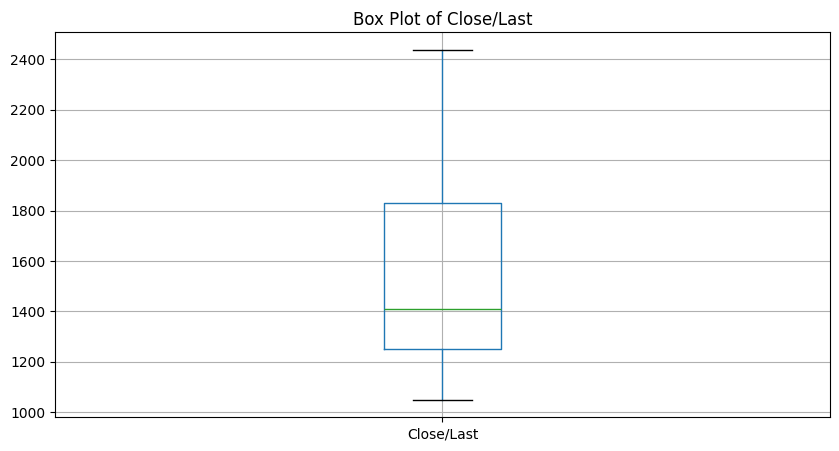

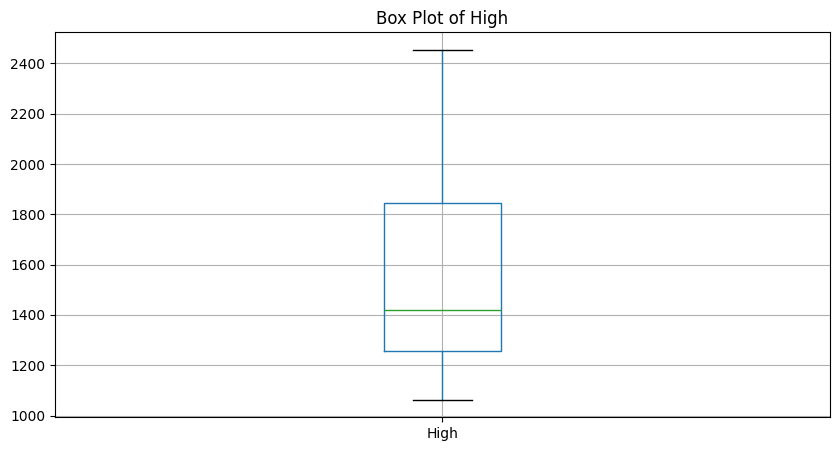

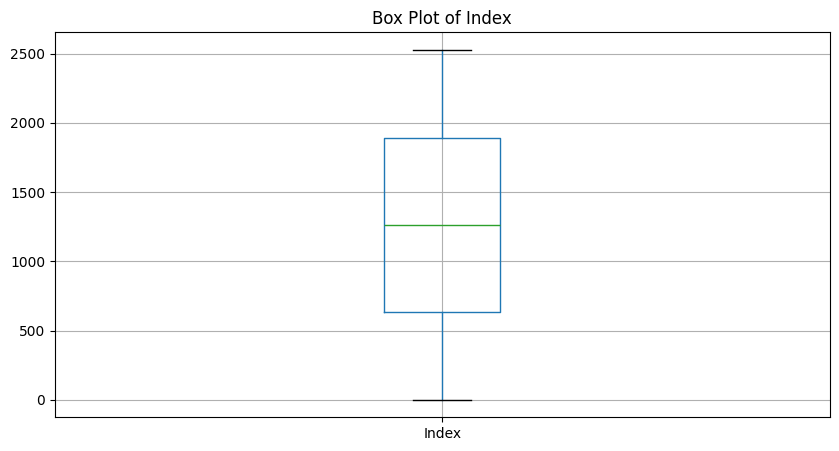

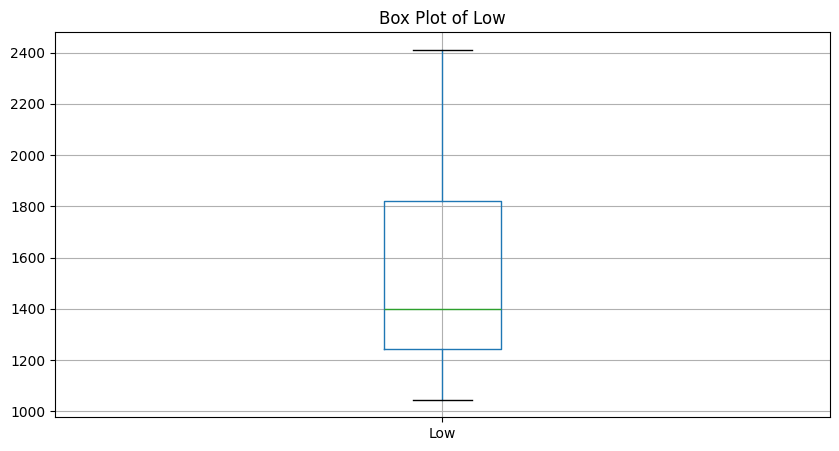

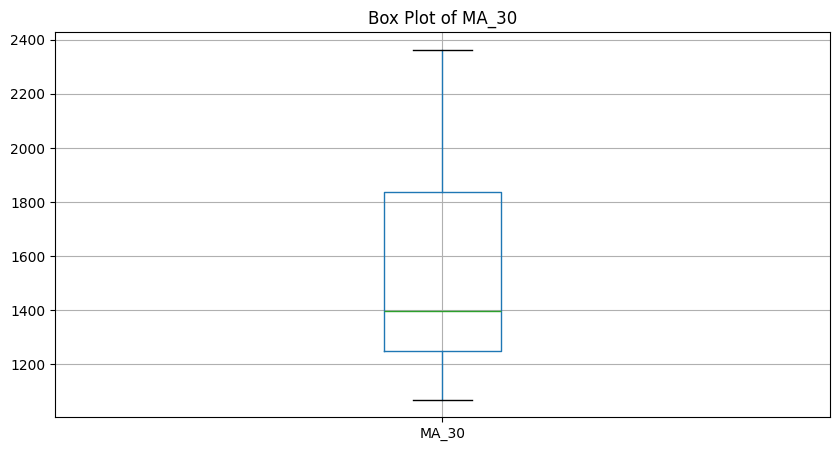

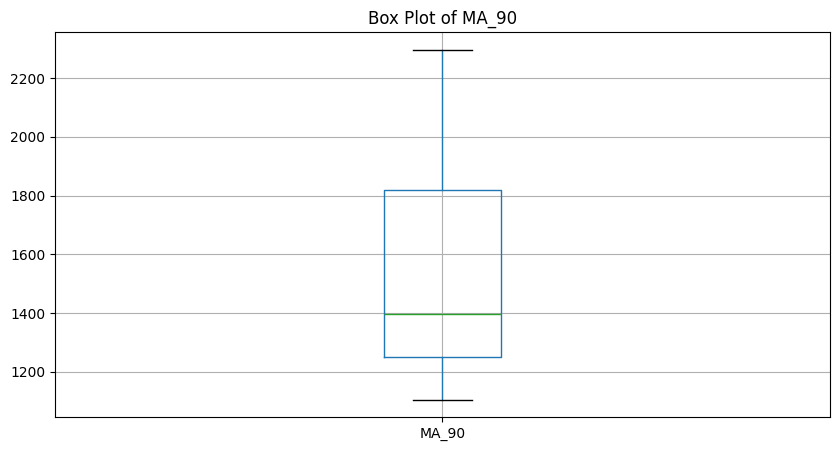

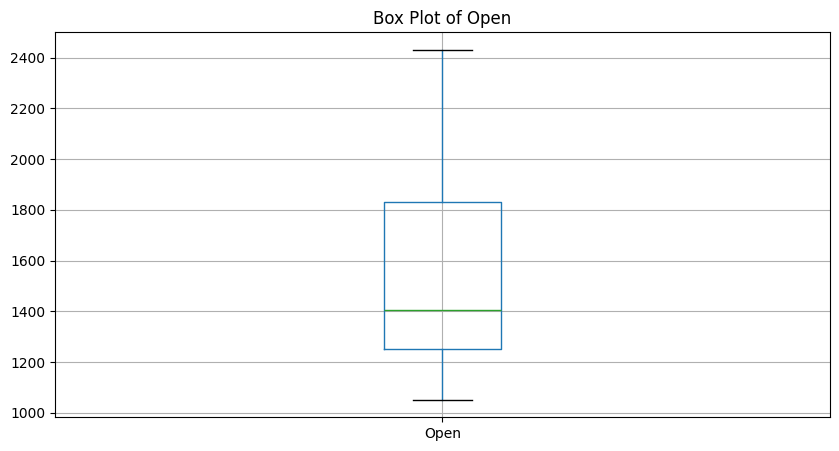

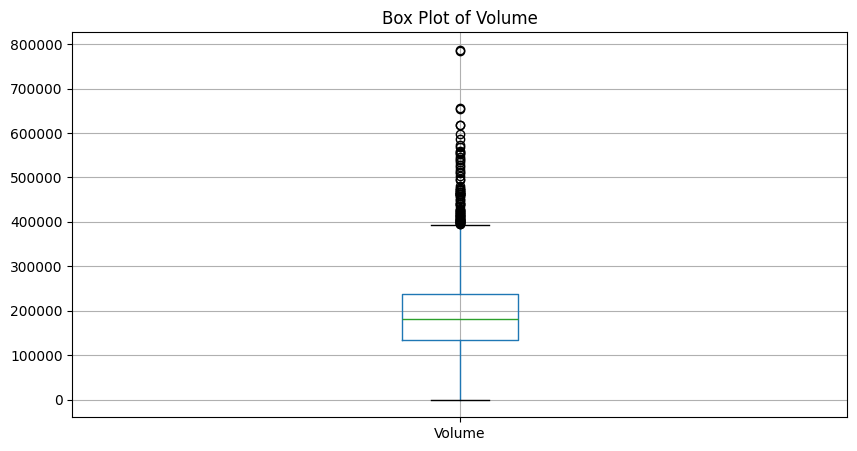

In [16]:

# List of features to plot
features = df.columns.difference(['Date'])

# Plot box plots for each feature separately
for feature in features:
    plt.figure(figsize=(10, 5))
    df.boxplot(column=[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

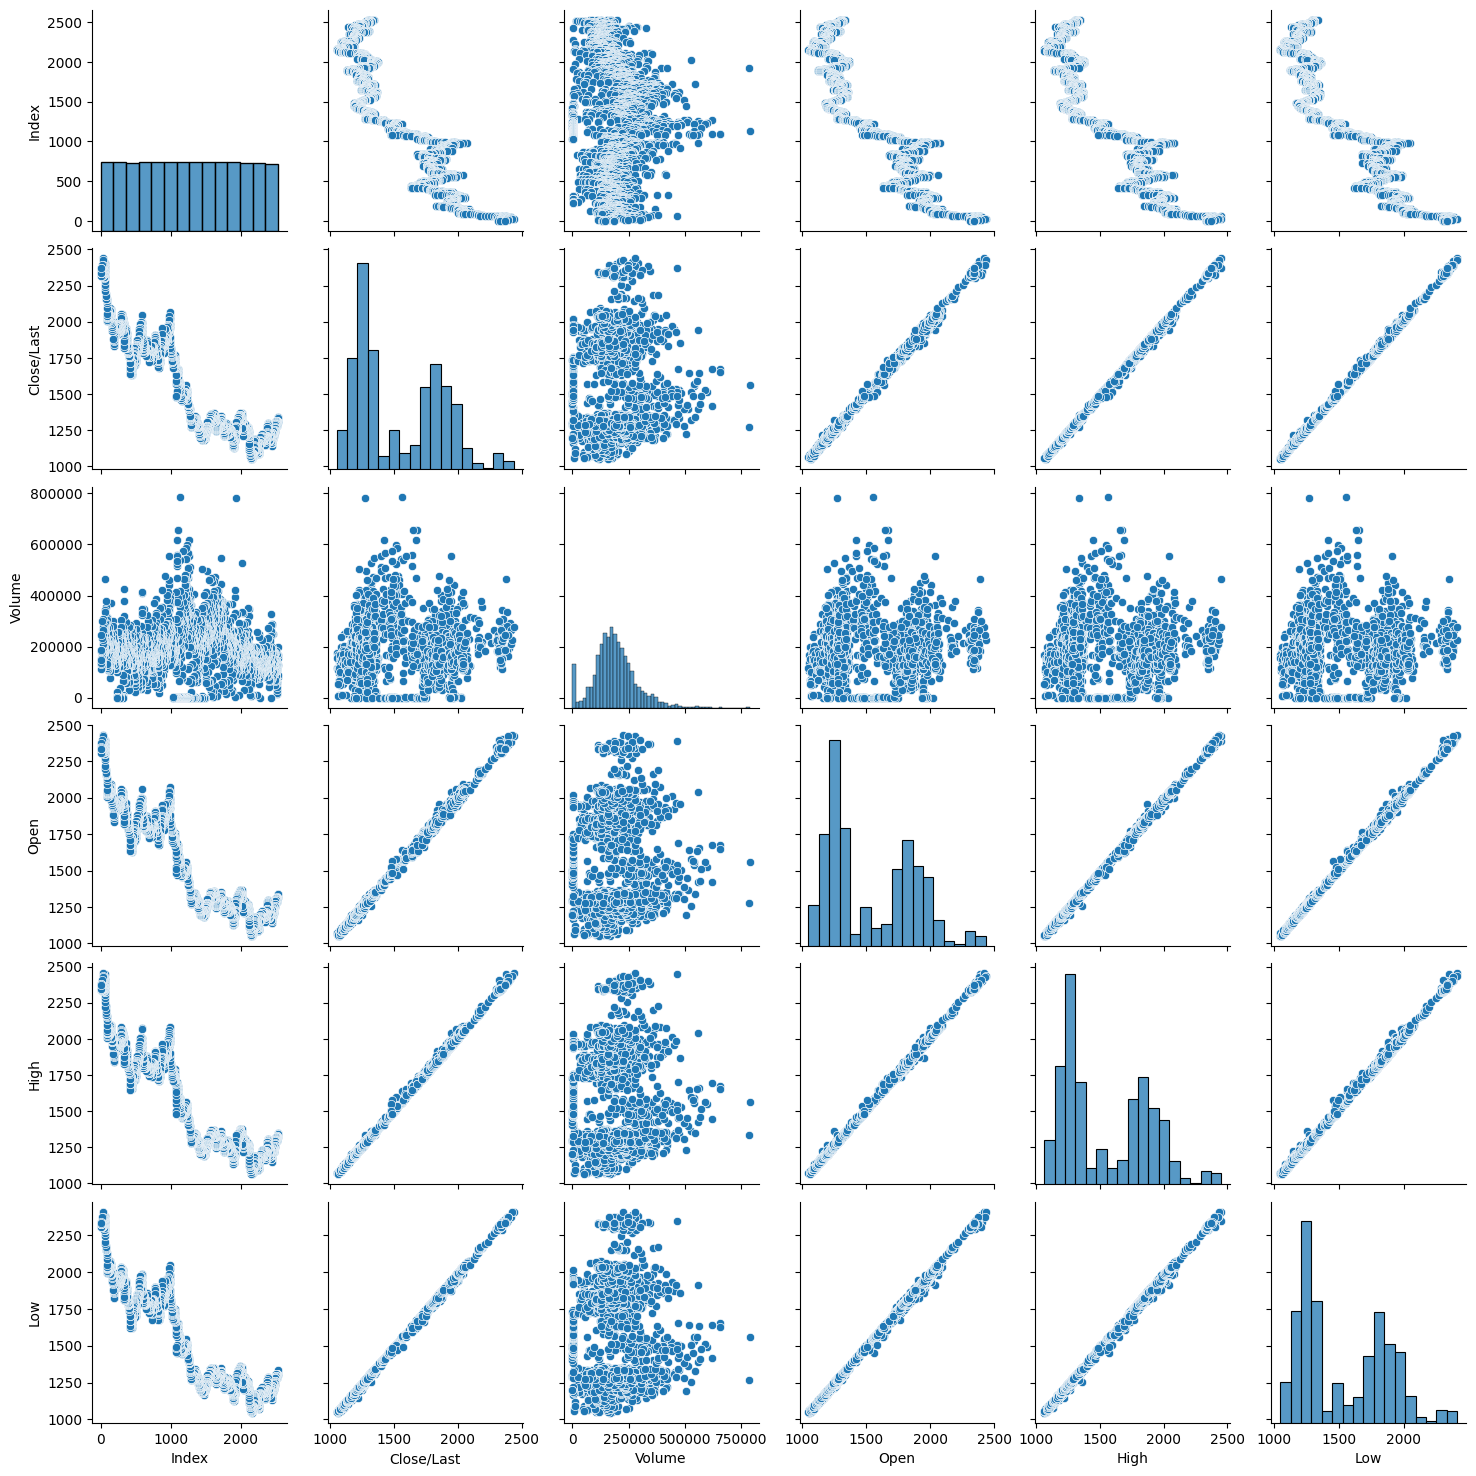

In [10]:
# Plot pair plots to visualize relationships between features
sns.pairplot(df)
plt.show()

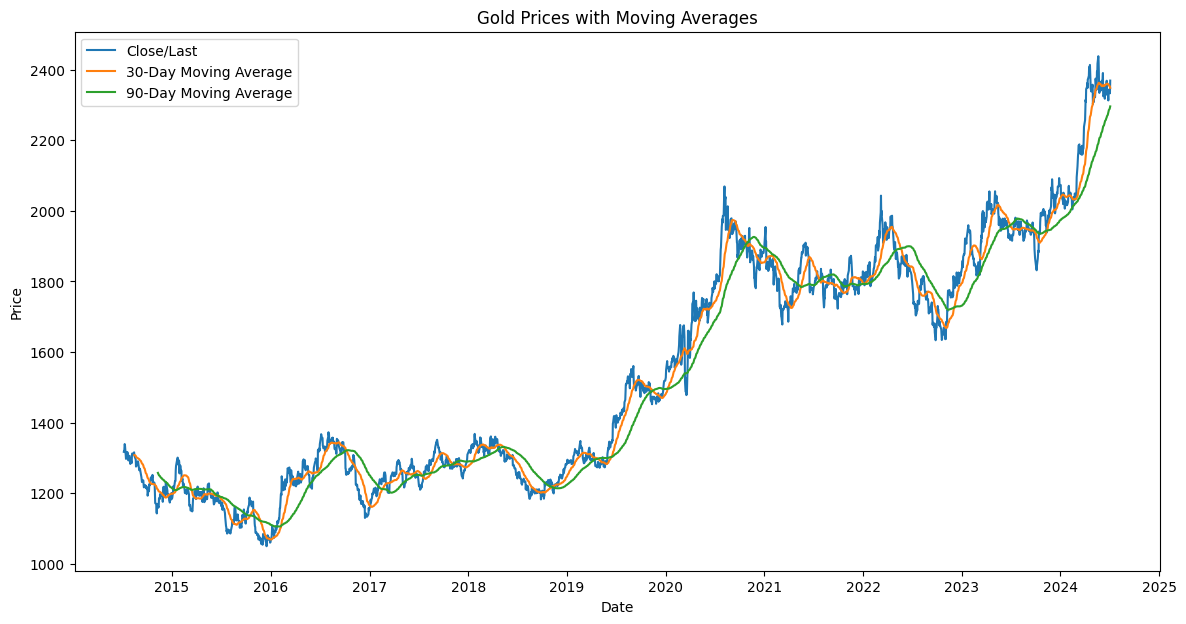

In [13]:
# Calculate moving averages
df['MA_30'] = df['Close/Last'].rolling(window=30).mean()
df['MA_90'] = df['Close/Last'].rolling(window=90).mean()

# Plot the moving averages
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'], label='Close/Last')
plt.plot(df['MA_30'], label='30-Day Moving Average')
plt.plot(df['MA_90'], label='90-Day Moving Average')
plt.title('Gold Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

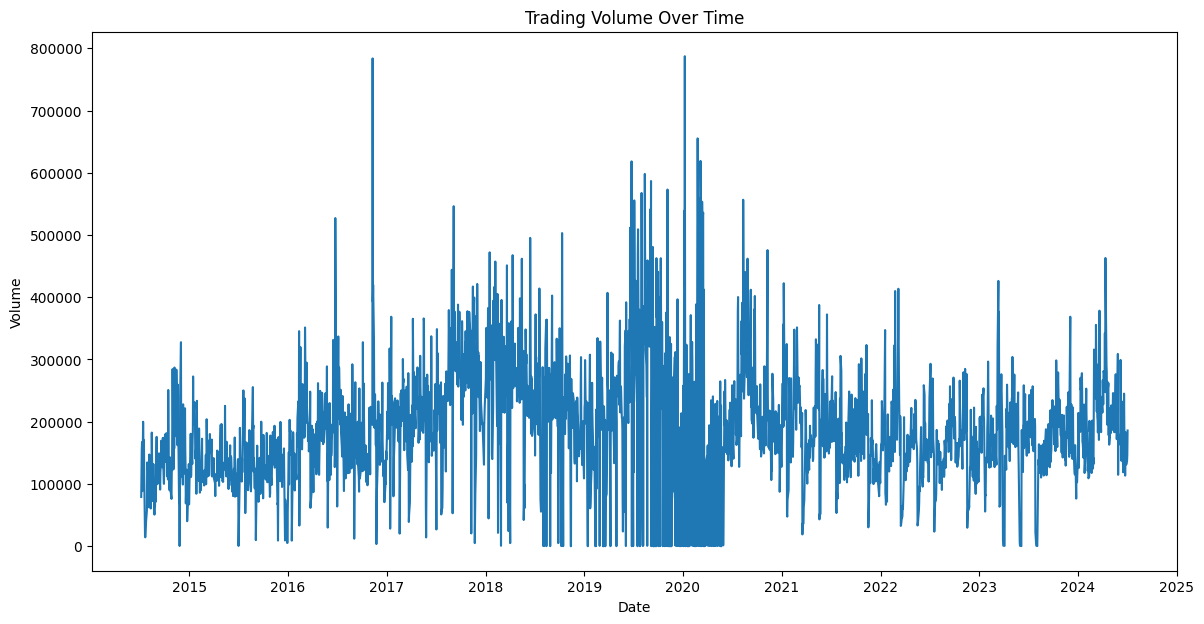

In [14]:
# Plot the volume over time
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Feature Engineering

We have two options: 
- Remove the Volume since it is not correlated with the closing, and model only with the other features

- Leave the Volume and just hope that the model can do something with it, but then you need to normalize the features

- Since I have no idea what I am doing, I will try first with the volume 

In [2]:
#### Dataset with the Volume feature
df_with_volume = df.copy()

### Dataset without the Volume feature
df_without_volume = df.drop(columns=['Volume'])

In [3]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Normalize the features
df_with_volume[['Close/Last', 'Volume', 'Open', 'High', 'Low']] = scaler.fit_transform(df_with_volume[['Close/Last', 'Volume', 'Open', 'High', 'Low']])

## Shifting Windows no volume (simple approach)

In [4]:


# Sort the dataframe by date
df_without_volume = df_without_volume.sort_values('Date')

# Define window sizes for lag features and rolling statistics
window_sizes = [10, 20, 50, 200]
rolling_windows = [20, 50, 200]

# Dictionary to store dataframes for each window size
dfs_by_window_size = {}

# Create separate dataframes for each window size
for window_size in window_sizes:
    # Create a copy of the original dataframe
    df_window = df_without_volume.copy()
    
    # Create lag features for the current window size
    for i in range(1, window_size + 1):
        df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
    
    # Add rolling statistics for the current window size if applicable
    if window_size in rolling_windows:
        df_window[f'Close/Last_Rolling_Mean_{window_size}'] = df_window['Close/Last'].rolling(window=window_size).mean()
        df_window[f'Close/Last_Rolling_Std_{window_size}'] = df_window['Close/Last'].rolling(window=window_size).std()
    
    # Drop rows with NaN values (which will be the first 'window_size' rows for the largest window size)
    df_window = df_window.dropna()
    
    # Reset index after dropping rows
    df_window = df_window.reset_index(drop=True)
    
    # Store the dataframe in the dictionary
    dfs_by_window_size[window_size] = df_window

# Display the first few rows of each dataframe to verify the lag features and rolling stats
for window_size, df in dfs_by_window_size.items():
    print(f"DataFrame for window size {window_size}:")
    print(df.shape)
    print("\n")

DataFrame for window size 10:
(2501, 16)


DataFrame for window size 20:
(2491, 28)


DataFrame for window size 50:
(2461, 58)


DataFrame for window size 200:
(2311, 208)




C:\Users\Vaquita\AppData\Local\Temp\ipykernel_7772\1725717435.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
C:\Users\Vaquita\AppData\Local\Temp\ipykernel_7772\1725717435.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_window[f'Close/Last_Lag_{i}_Window_{window_size}'] = df_window['Close/Last'].shift(i)
C:\Users\Vaquita\AppData\Local\Temp\ipykernel_7772\1725717435.py:21: PerformanceWarning: DataFrame is highly fragmented.  This

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

# Split the data into training and testing sets
train_size = int(0.8 * len(df_without_volume))
train_df = df_without_volume[:train_size]
test_df = df_without_volume[train_size:]

X_train = train_df.drop(columns=['Close/Last'])
y_train = train_df['Close/Last']
X_test = test_df.drop(columns=['Close/Last'])
y_test = test_df['Close/Last']

# Remove features with low variance
selector = VarianceThreshold(threshold=0.01)
X_train_reduced = selector.fit_transform(X_train)
X_test_reduced = selector.transform(X_test)

# Select top k features based on correlation with the target
k = 50  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_train_reduced = selector.fit_transform(X_train_reduced, y_train)
X_test_reduced = selector.transform(X_test_reduced)



## Shifting Windows volume (simple approach)

In [5]:
# Ensure the 'Date' column is in datetime format
df_with_volume['Date'] = pd.to_datetime(df_with_volume['Date'], dayfirst=True)

# Sort the dataframe by date
df_with_volume = df_with_volume.sort_values('Date')

# Create lag features with a window size of 5
window_size = 5
for i in range(1, window_size + 1):
    df_with_volume[f'Close/Last_Lag_{i}'] = df_with_volume['Close/Last'].shift(i)

# Add rolling statistics for 'Close/Last'
df_with_volume['Close/Last_Rolling_Mean_5'] = df_with_volume['Close/Last'].rolling(window=window_size).mean()
df_with_volume['Close/Last_Rolling_Std_5'] = df_with_volume['Close/Last'].rolling(window=window_size).std()

# Drop rows with NaN values (which will be the first 'window_size' rows)
df_with_volume = df_with_volume.dropna()

# Reset index after dropping rows
df_with_volume = df_with_volume.reset_index(drop=True)

# Display the first few rows of the dataframe to verify the lag features and rolling stats
print(df_with_volume)

      Index       Date  Close/Last    Volume      Open      High       Low  \
0      2523 2014-07-14   -0.702941  0.100275 -0.604365 -0.625453 -0.691743   
1      2522 2014-07-15   -0.731721 -0.213203 -0.695483 -0.704250 -0.720770   
2      2521 2014-07-16   -0.723627 -0.834708 -0.737146 -0.734579 -0.718048   
3      2520 2014-07-17   -0.672362 -0.205480 -0.721859 -0.670055 -0.704140   
4      2519 2014-07-18   -0.694847 -0.759655 -0.665510 -0.671244 -0.683276   
...     ...        ...         ...       ...       ...       ...       ...   
2501      4 2024-06-27    2.384608 -0.562478  2.302722  2.351282  2.345829   
2502      3 2024-06-28    2.393602 -0.609901  2.390244  2.376854  2.415071   
2503      2 2024-07-01    2.391503 -0.551358  2.383050  2.371502  2.410536   
2504      1 2024-07-02    2.375015 -0.451133  2.399236  2.363474  2.408117   
2505      0 2024-07-03    2.482940 -0.044720  2.390244  2.447920  2.433213   

      Close/Last_Lag_1  Close/Last_Lag_2  Close/Last_Lag_3  Clo

# Model Selection

##  Prophet

In [4]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Rename the columns to match Prophet's requirements
df.rename(columns={'Date': 'ds', 'Close/Last': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize the Prophet model
model = Prophet()

# Fit the model on the training set
model.fit(train_df[['ds', 'y']])

# Make predictions on the test set
future = test_df[['ds']]
forecast = model.predict(future)

# Calculate MSE and R²
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 45495.06279289315
R-squared: -0.23418277528830989


### Linear Reg

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Parse dates and set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Hyperparameter tuning using Grid Search
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test_scaled)

best_mse = mean_squared_error(y_test, best_predictions)
print(f'Best Mean Squared Error: {best_mse}')

Mean Squared Error: 276.761315010601
Mean Absolute Error: 12.398099302712671
R-squared: 0.9924920633826319
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Mean Squared Error: 276.761315010601


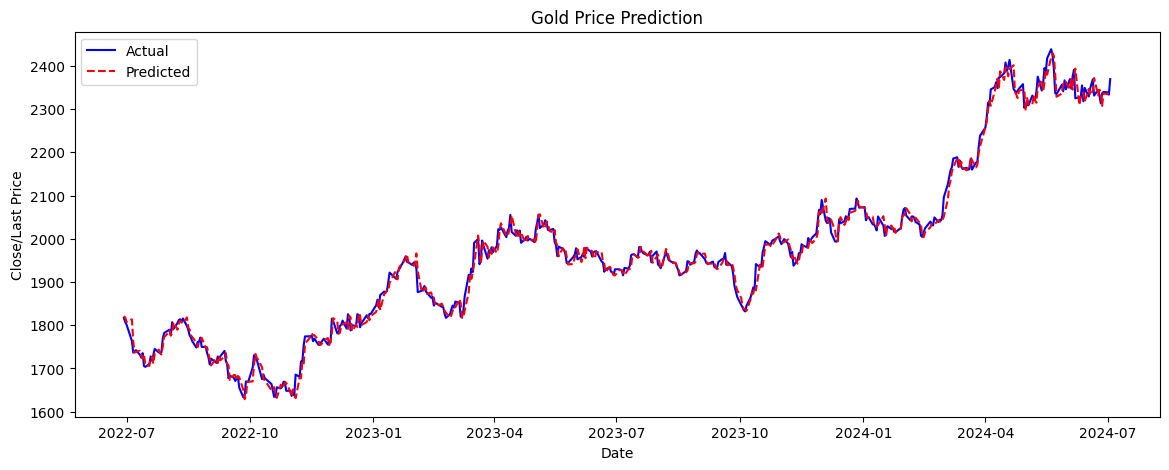

In [20]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, best_predictions, label='Predicted', color='red', linestyle='--')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()

## Catboost reg

In [9]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Parse dates and set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Initialize and train the model
model = CatBoostRegressor(iterations=100, verbose=0)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Hyperparameter tuning using Grid Search
param_grid = {
    'iterations': [50, 100, 200],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)

best_mse = mean_squared_error(y_test, best_predictions)
print(f'Best Mean Squared Error: {best_mse}')

Mean Squared Error: 16111.423823195295
Mean Absolute Error: 62.231243779681606
R-squared: 0.5629318755207096
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Mean Squared Error: 16097.015745121229


## RF Reg

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Parse dates and set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Handle missing values
df.dropna(inplace=True)


# Drop rows with NaN values generated by moving averages
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)

best_mse = mean_squared_error(y_test, best_predictions)
print(f'Best Mean Squared Error: {best_mse}')


Mean Squared Error: 15658.351761275038
Mean Absolute Error: 63.66664896967408
R-squared: 0.5752227418358493
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Mean Squared Error: 15327.648075079565


## LSTM

Epoch 1/50


C:\Users\Vaquita\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0125 - val_loss: 0.0013
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2808e-04 - val_loss: 0.0022
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0696e-04 - val_loss:

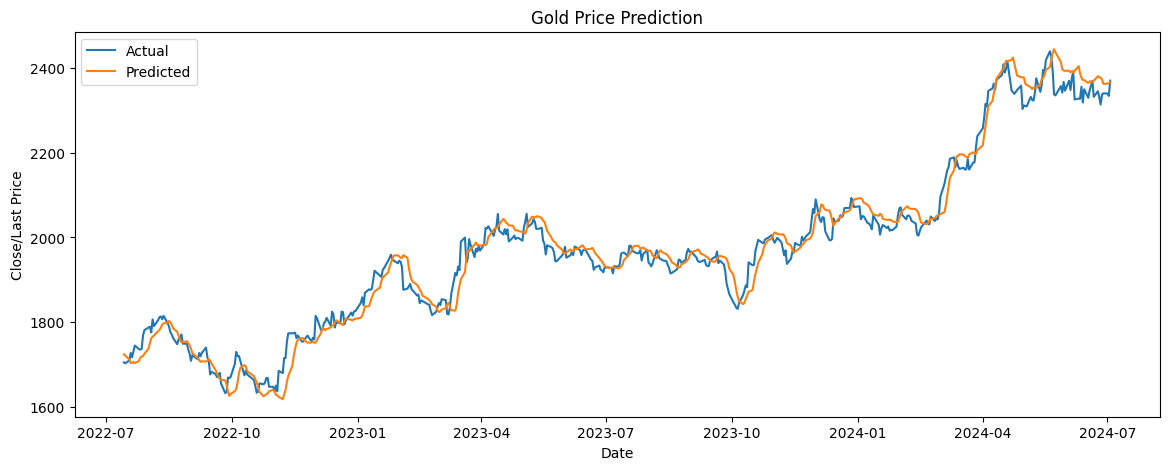

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted Close/Last for the next day: 2367.586669921875


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('goldstock.csv')

# Parse dates and set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

# Sort the dataset by date
df.sort_index(inplace=True)

# Handle missing values
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Data scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

# Make predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Evaluate the model
y_test_actual = scaler_y.inverse_transform(y_test_seq)

mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)


In [3]:
# Save the model
model.save('gold_price_prediction_model.h5')

In [ ]:

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(test.index[time_steps:], y_test_actual, label='Actual')
plt.plot(test.index[time_steps:], y_pred, label='Predicted')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close/Last Price')
plt.legend()
plt.show()

# Forecasting future values
last_sequence = X_test_scaled[-time_steps:]
last_sequence = np.expand_dims(last_sequence, axis=0)
future_prediction_scaled = model.predict(last_sequence)
future_prediction = scaler_y.inverse_transform(future_prediction_scaled)
print(f'Predicted Close/Last for the next day: {future_prediction[0][0]}')

# Model Evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load and preprocess the dataset
df = pd.read_csv('goldstock.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Feature selection
features = ['Open']
X_train = train[features]
y_train = train['Close/Last']
X_test = test[features]
y_test = test['Close/Last']

# Normalize the data for models that require it
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Function to evaluate and store results
results = {}
predictions = {}

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    predictions[name] = y_pred
    print(f'{name} - MSE: {mse}, MAE: {mae}, R2: {r2}')


In [2]:

# Prophet Model
def prophet_model(train, test):
    train_df = train.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    test_df = test.reset_index().rename(columns={'Date': 'ds', 'Close/Last': 'y'})
    model = Prophet()
    model.fit(train_df[['ds', 'y']])
    future = test_df[['ds']]
    forecast = model.predict(future)
    y_pred = forecast['yhat'].values
    evaluate_model('Prophet', test_df['y'].values, y_pred)

# Linear Regression Model
def linear_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('Linear Regression', y_test, y_pred)

# Random Forest Model
def random_forest_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('Random Forest', y_test, y_pred)

# LightGBM Model
def lightgbm_model(X_train, y_train, X_test, y_test):
    model = lgb.LGBMRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model('LightGBM', y_test, y_pred)

# LSTM Model
def lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled):
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, shuffle=False)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)

from keras.models import load_model

def lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path):
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

    # Load the pre-trained model
    model = load_model(path)

    y_pred_scaled = model.predict(X_test_seq)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_actual = scaler_y.inverse_transform(y_test_seq)
    evaluate_model('LSTM', y_test_actual, y_pred)


### Run all models

In [3]:
prophet_model(train, test)

12:07:57 - cmdstanpy - INFO - Chain [1] start processing
12:07:58 - cmdstanpy - INFO - Chain [1] done processing


Prophet - MSE: 45495.06279289315, MAE: 162.31036549031757, R2: -0.23418277528830989


In [4]:
linear_regression_model(X_train_scaled, y_train, X_test_scaled, y_test)

Linear Regression - MSE: 276.761315010601, MAE: 12.398099302712678, R2: 0.9924920633826319


In [5]:
random_forest_model(X_train, y_train, X_test, y_test)

Random Forest - MSE: 16213.695337945774, MAE: 65.0119552431445, R2: 0.560157470252114


In [6]:
lightgbm_model(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 1
[LightGBM] [Info] Start training from score 1434.292979
LightGBM - MSE: 18673.43176560044, MAE: 70.12665787835996, R2: 0.49343013448426876


In [7]:
path = "gold_price_prediction_model.h5"
lstm_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, path)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
LSTM - MSE: 1037.0268547685444, MAE: 25.49753363495183, R2: 0.9717384560132398


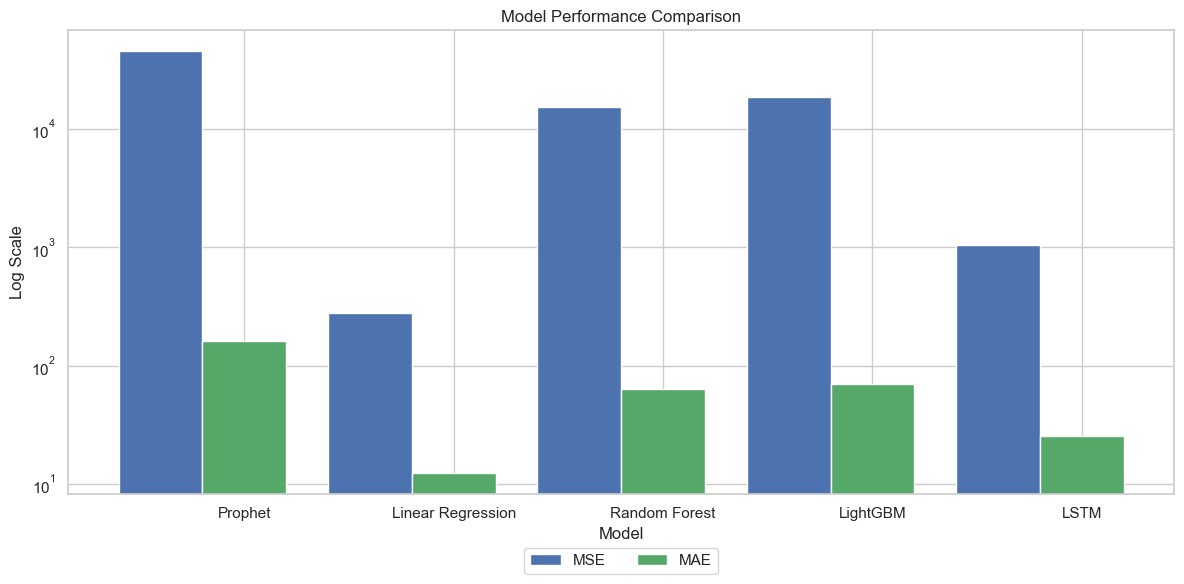

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the results
metrics = ['MSE', 'MAE']
colors = ['b', 'g']

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4
index = np.arange(len(results))

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    ax.bar(index + i * bar_width, values, bar_width, label=metric, color=colors[i])

ax.set_xlabel('Model')
ax.set_ylabel('Log Scale')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(results.keys())
ax.set_yscale('log')  # Set y-axis to log scale
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(metrics))

plt.tight_layout()
plt.show()

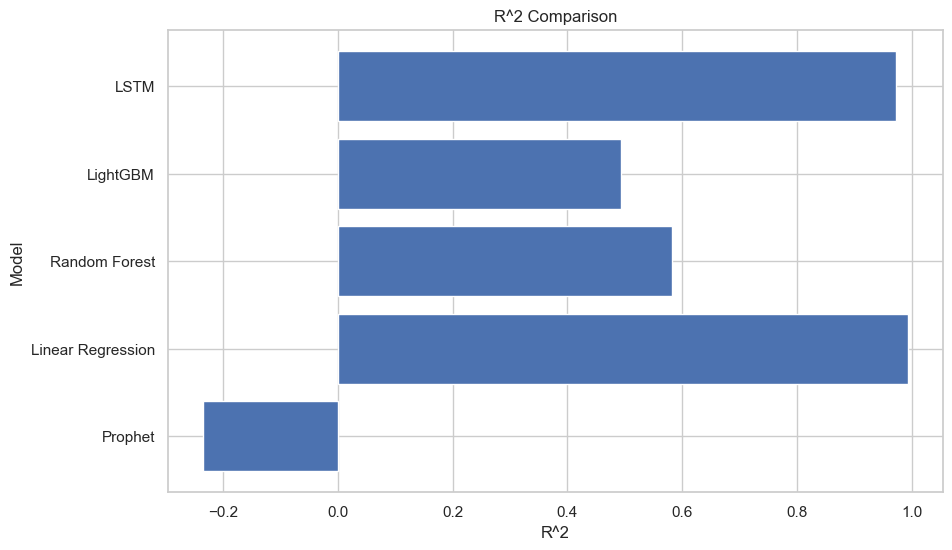

In [44]:
# Plot the R^2 separately in a horizontal bar setup
plt.figure(figsize=(10, 6))
plt.barh(list(results.keys()), [results[model]['R2'] for model in results])
plt.title('R^2 Comparison')
plt.xlabel('R^2')
plt.ylabel('Model')
plt.show()

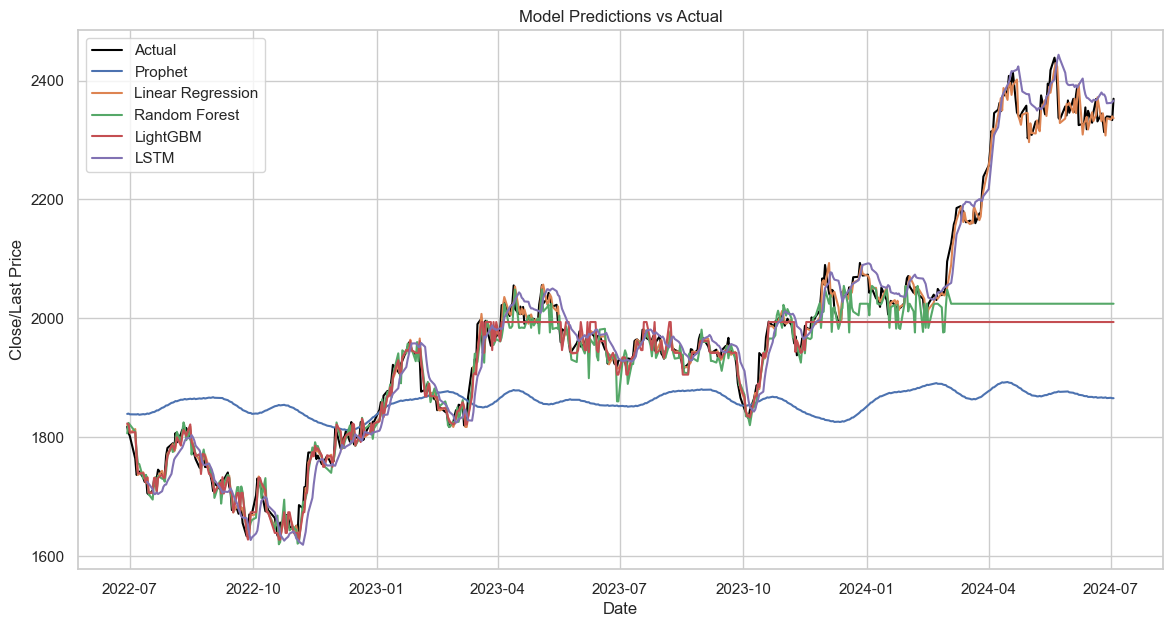

In [46]:
# Function to plot predictions
def plot_predictions(test, predictions):
    plt.figure(figsize=(14, 7))
    plt.plot(test.index, test.values, label='Actual', color='black')
    for model_name, y_pred in predictions.items():
        # Adjust the length of the test set to match the length of the predictions
        if len(y_pred) < len(test):
            plt.plot(test.index[-len(y_pred):], y_pred, label=model_name)
        else:
            plt.plot(test.index, y_pred, label=model_name)
    plt.xlabel('Date')
    plt.ylabel('Close/Last Price')
    plt.title('Model Predictions vs Actual')
    plt.legend()
    plt.show()


# Plot predictions
plot_predictions(test['Close/Last'], predictions)

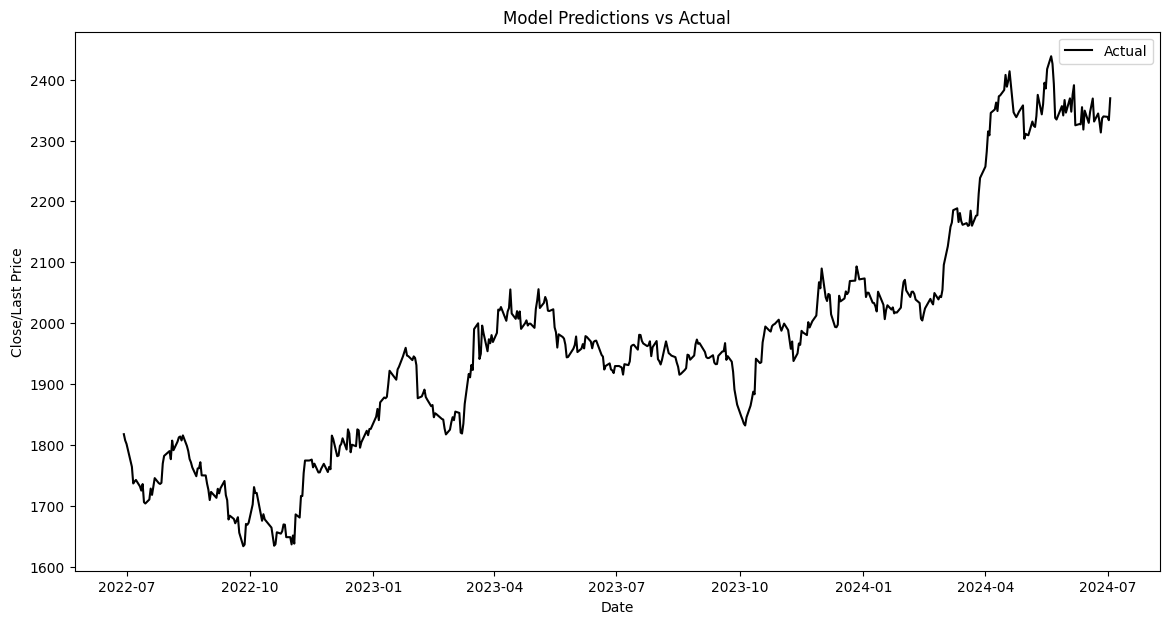

In [12]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Function to plot predictions
def plot_predictions(test, predictions, selected_models):
    plt.figure(figsize=(14, 7))
    plt.plot(test.index, test.values, label='Actual', color='black')
    for model_name in selected_models:
        y_pred = predictions.get(model_name)
        if y_pred is not None:
            if len(y_pred) < len(test):
                plt.plot(test.index[-len(y_pred):], y_pred, label=model_name)
            else:
                plt.plot(test.index, y_pred, label=model_name)
    plt.xlabel('Date')
    plt.ylabel('Close/Last Price')
    plt.title('Model Predictions vs Actual')
    plt.legend()
    plt.show()

# Interactive widget for model selection
model_options = list(predictions.keys())
model_checkboxes = [widgets.Checkbox(value=False, description=model) for model in model_options]
output = widgets.Output()

def update_plot(change):
    selected_models = [cb.description for cb in model_checkboxes if cb.value]
    with output:
        output.clear_output(wait=True)
        plot_predictions(test['Close/Last'], predictions, selected_models)

for cb in model_checkboxes:
    cb.observe(update_plot, 'value')

# Display the widgets and initial plot
display(widgets.VBox(model_checkboxes))
display(output)

# Initial plot with no models selected
update_plot(None)

In [10]:
jupyter nbextension enable --py widgetsnbextension --sys-prefix

SyntaxError: invalid syntax (4053252937.py, line 1)